# Data Cleaning & EDA

In [1]:
#imoprting libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# importing Reddit CSV 
reddit = pd.read_csv('./data/reddit.csv')

In [3]:
# inspecting dataframe
reddit.head(2)

,created_utc,num_comments,score,subreddit,title,is_nfl
0,1633046573,61,1,nfl,Lamar Jackson Hate,1
1,1633046634,103,1,nfl,[Lombardi] 49ers continue advocating for a rul...,1


In [4]:
# converting epoch to datetime and dropping original column - inspiration from https://tinyurl.com/4hr9uykt
reddit['date'] = pd.to_datetime(reddit['created_utc'], unit='s')
reddit.drop(columns = 'created_utc', inplace = True)

In [5]:
# converting datetime to date
reddit['date'] = pd.to_datetime(reddit['date']).dt.date.astype(("datetime64"))

In [6]:
# checking total number of observations
reddit.shape

(1929, 6)

In [7]:
# checking total count of each y value
reddit['is_nfl'].value_counts()

0    993
1    936
Name: is_nfl, dtype: int64

In [8]:
# normalizing to determine baseline model score (51.48%)
reddit['is_nfl'].value_counts(normalize = True)

0    0.514774
1    0.485226
Name: is_nfl, dtype: float64

In [9]:
# checking value counts across dates. Some came just shy of hitting the max 100 posts allowed per pull by Reddit
reddit['date'].value_counts()

2021-10-10    200
2021-10-08    200
2021-10-07    200
2021-10-06    200
2021-10-05    200
2021-10-04    200
2021-10-03    200
2021-10-01    200
2021-10-09    168
2021-10-02    161
Name: date, dtype: int64

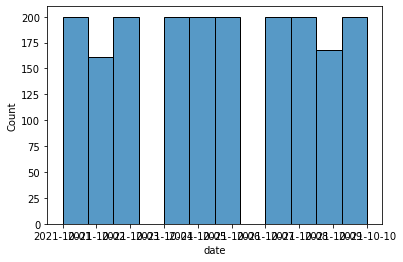

In [10]:
# histplot of the same value counts to help visualize - unsure why gaps are displayed here
sns.histplot(data = reddit, x = 'date');

In [11]:
# making sure dtypes are still appropriate
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num_comments  1929 non-null   int64         
 1   score         1929 non-null   int64         
 2   subreddit     1929 non-null   object        
 3   title         1929 non-null   object        
 4   is_nfl        1929 non-null   int64         
 5   date          1929 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 90.5+ KB


In [12]:
# checking for null values - looks good
reddit.isnull().sum()

num_comments    0
score           0
subreddit       0
title           0
is_nfl          0
date            0
dtype: int64

In [13]:
# Function to clean and separate titles using regex, and then Stem/Lem the cleaned text and filter stop words. Courtesy Breakfast Hour lesson. Thanks Katie!
def cleaner_rev(review):
    # Set token & instantiate Lem/Stem
    lemmatizer = WordNetLemmatizer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 
    
    # Tokenize words
    words = my_tokenizer.tokenize(review.lower())
    # What about stop words??
    stop_word_list = stopwords.words('english')
    no_stops = [i for i in words if i not in stop_word_list]
    # Lem/Stem
    rev_lem = [lemmatizer.lemmatize(i) for i in no_stops]
    # Put words back together
    return ' '.join(rev_lem)

In [14]:
# adding column of the cleaned titles
reddit['clean_title'] = reddit['title'].map(cleaner_rev)

In [15]:
# adding column for word count of original titles (prior to cleaning)
reddit['word_count'] = reddit['title'].str.split().str.len()

In [16]:
# determining average word count (title) for each subreddit
reddit.groupby(by='is_nfl').mean('word_count')

,num_comments,score,word_count
is_nfl,,,
0,251.851964,15.359517,12.485398
1,262.121795,51.992521,19.237179


In [17]:
# confirming there aren't issues with new columns
reddit.head()

,num_comments,score,subreddit,title,is_nfl,date,clean_title,word_count
0,61,1,nfl,Lamar Jackson Hate,1,2021-10-01,lamar jackson hate,3
1,103,1,nfl,[Lombardi] 49ers continue advocating for a rul...,1,2021-10-01,lombardi 49ers continue advocating rule change...,49
2,37,1,nfl,Is it just a coincidence that Golden Tate and ...,1,2021-10-01,coincidence golden tate auden tate au chemical...,23
3,62,1,nfl,[Highlight] James Robinson 6-YD TD Run. Jags I...,1,2021-10-01,highlight james robinson 6 yd td run jag impre...,10
4,30,1,nfl,Qb vs oline,1,2021-10-01,qb v oline,3


In [18]:
# Create CSV from final DF
reddit.to_csv('./data/reddit_clean.csv', index = False)

Given what has been collected here we should have the appropriate data to begin building a successful model that addresses the problem statement.